# Experiment 1

How well do TPMS scores predict bids?

The deliverable will be a plot showing the performance of the TPMS scores on the "recall@M" evaluation metric.

Plan:
- load eval data for UAI 18 conference
- load a model (which could be pre-trained, if the model requires training)
- evaluate the model and produce graphs

In [25]:
%load_ext autoreload
%autoreload 2

import os, sys

import json, csv
import itertools

import openreview
import numpy
sys.path.append('..')
from collections import defaultdict
from expertise.models import tfidf, randomize, model_utils

## Data


Load up data and organize it into various indices

In [4]:
data_dir = '../data/uai18/'

submission_records_dir = os.path.join(data_dir, 'submission_records_fulltext')
reviewer_archives_dir = os.path.join(data_dir, 'reviewer_archives')
reviewer_bids_file = os.path.join(data_dir, 'reviewer_bids.jsonl')
tfidf_scores_file = os.path.join(data_dir, 'tfidf-score-matrix.txt')
tpms_scores_file = os.path.join(data_dir,'tpms-score-matrix.txt')
random_scores_file = os.path.join(data_dir, 'random-score-matrix.txt')

papers = []
for filename in os.listdir(submission_records_dir):
    with open(os.path.join(submission_records_dir, filename)) as f:
        papers.append(openreview.Note(**json.load(f)))
        
paper_by_number = {n.number: n for n in papers}

In [5]:
reviewer_ids = []
for filename in os.listdir(reviewer_archives_dir):
    reviewer_ids.append(filename.replace('.jsonl',''))

In [6]:
all_bids = []

with open(reviewer_bids_file) as f:
    for line in f.readlines():
        all_bids.append(openreview.Tag.from_json(json.loads(line.replace('\n',''))))

In [7]:
binned_bids = {
    'i want to review': [],
    'i can review': [],
    'i can probably review but am not an expert': [],
    'i cannot review': [],
    'no bid': []
}

users_w_bids = set()
for bid in all_bids:
    binned_bids[bid.tag.lower()].append(bid)
    users_w_bids.update(bid.signatures)

for b in binned_bids:
    print(b, len(binned_bids[b]))

bids_by_forum = defaultdict(list)
for bid in all_bids:
    bids_by_forum[bid.forum].append(bid)

i want to review 1486
i can review 2256
i can probably review but am not an expert 2633
i cannot review 9024
no bid 754


## Scores

In [8]:
def read_scores(file):
    score_matrix = {}
    with open(file) as f:
        lines = [line.replace('\n','') for line in f.readlines()]

    for line in lines:
        note_id, reviewer_id, score = eval(line)
        if note_id not in score_matrix:
            score_matrix[note_id] = {}
        if reviewer_id not in score_matrix[note_id]:
            score_matrix[note_id][reviewer_id] = score
        else:
            raise('pair already seen ', note_id, reviewer_id, score)

    ranklists = model_utils.matrix_to_ranklists(score_matrix)
    return ranklists


tfidf_ranklists = read_scores(tfidf_scores_file)
tpms_ranklists = read_scores(tpms_scores_file)
random_ranklists = read_scores(random_scores_file)

## Evaluation & Graphing

In [26]:
from expertise.evaluators import recall_at_m, mean_avg_precision
from expertise import graphing
import numpy as np
import matplotlib, matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [10]:
evaluator = recall_at_m.Evaluator(bids_by_forum=bids_by_forum)

In [11]:
def get_avg_scores(ranklists, evaluator):
    all_scores = []
    for forum, scores in evaluator.evaluate(ranklists):
        all_scores.append(scores)
    if all_scores:
        avg_scores = np.mean(all_scores, axis=0)
    else:
        avg_scores = []
        
    return avg_scores

In [12]:
%%time
tpms_avg_scores = get_avg_scores(tpms_ranklists, evaluator)
tfidf_avg_scores = get_avg_scores(tfidf_ranklists, evaluator)
random_avg_scores = get_avg_scores(random_ranklists, evaluator)

CPU times: user 1.4 s, sys: 203 µs, total: 1.4 s
Wall time: 1.4 s


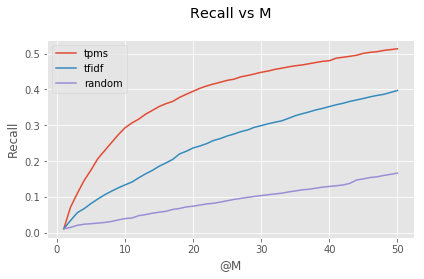

In [13]:
fig, ax = plt.subplots()

ax = graphing.recall_at_m(tpms_avg_scores, ax, 'tpms')
ax = graphing.recall_at_m(tfidf_avg_scores, ax, 'tfidf')
ax = graphing.recall_at_m(random_avg_scores, ax, 'random')

plt.tight_layout()

# filename = 'tpms-tfidf-random-filtered_ranklist'
# fig.savefig("./{0}.png".format(filename), dpi=200)

In [28]:
# Implement MAP or NDCG? 

evaluator = mean_avg_precision.Evaluator(bids_by_forum=bids_by_forum)
tpms_avg_scores = get_avg_scores(tpms_ranklists, evaluator)
tfidf_avg_scores = get_avg_scores(tfidf_ranklists, evaluator)
random_avg_scores = get_avg_scores(random_ranklists, evaluator)
print(tfidf_avg_scores)
print(tpms_avg_scores)
print(random_avg_scores)

[0.17879299]
[0.37951483]
[0.05134401]
